#1: Import Libraries

In [3]:
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger
from tensorflow.keras.preprocessing import image
from keras.models import load_model
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import glob
import os
import shutil
import math

import time

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


In [1]:
# Connect the driver
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 2: Build A Model

##2.1: Transfer learning - VGG16 model

In [ ]:
base_model = keras.applications.VGG16(
    weights="imagenet",
    input_shape=(224, 224, 3),
    include_top=False)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
base_model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

###2.1.1: Freeze the model

In [ ]:
base_model.trainable = False

### 2.2: Add the final layers

In [ ]:
inputs = keras.Input(shape=(224,224,3))

x = base_model(inputs, training=False)
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(512, activation = "relu")(x)
outputs = keras.layers.Dense(1, activation = "sigmoid")(x)

model = keras.Model(inputs,outputs)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      12,845,568 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 27,560,769 (105.14 MB)

 Trainable params: 12,846,081 (49.00 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

# 3: Prepare data for the model to train

In [ ]:
# @title
SEED_DATA_DIR = "/content/drive/MyDrive/projects/1_Image_classification/1_brain_tumor/datasets/slit_brain_tumor"
num_of_images = {}

for dir in os.listdir(SEED_DATA_DIR):
    num_of_images[dir] = len(os.listdir(os.path.join(SEED_DATA_DIR, dir )))
print (num_of_images)

TRAIN_DIR = "/content/datasets/train"
VALIDATE_DIR = "/content/datasets/valid"
TEST_DIR = "/content/datasets/test"

""" create the train folder """
if not os.path.exists(TRAIN_DIR):
    os.mkdir(TRAIN_DIR)

    for dir in os.listdir(SEED_DATA_DIR):
        os.makedirs(TRAIN_DIR + "/" + dir)
        print (TRAIN_DIR + "/" + dir)

        for img in np.random.choice(a=os.listdir(os.path.join(SEED_DATA_DIR,dir)) , size= (math.floor(70/100* num_of_images[dir] )-5) , replace=False ):
            O = os.path.join(SEED_DATA_DIR, dir , img)
            print(O)
            D = os.path.join(TRAIN_DIR, dir)
            print(D)
            shutil.copy(O,D)
            os.remove(O)
else:
    print("Train Folder Exists")

""" create the test folder """
if not os.path.exists(TEST_DIR):
    os.mkdir(TEST_DIR)

    for dir in os.listdir(SEED_DATA_DIR):
        os.makedirs(TEST_DIR + "/" + dir)
        print (TEST_DIR + "/" + dir)

        for img in np.random.choice(a=os.listdir(os.path.join(SEED_DATA_DIR,dir)), size= (math.floor(15/100 * num_of_images[dir]) - 5) , replace = False ):
            O = os.path.join(SEED_DATA_DIR, dir , img)
            D = os.path.join(TEST_DIR, dir)
            shutil.copy(O,D)
            os.remove(O)
else:
    print("Test Folder Exists")


""" create the validate folder """
if not os.path.exists(VALIDATE_DIR):
    os.mkdir(VALIDATE_DIR)

    for dir in os.listdir(SEED_DATA_DIR):
        os.makedirs(VALIDATE_DIR + "/" + dir)
        print (VALIDATE_DIR + "/" + dir)

        for img in np.random.choice(a=os.listdir(os.path.join(SEED_DATA_DIR,dir)), size= (math.floor(15/100 * num_of_images[dir]) - 5), replace = False ):
            O = os.path.join(SEED_DATA_DIR, dir , img)
            D = os.path.join(VALIDATE_DIR, dir)
            shutil.copy(O,D)
            os.remove(O)
else:
    print("Validate Folder Exists")

In [ ]:
datagen = ImageDataGenerator(
    rotation_range = 10,
    zoom_range = 0.2,
    shear_range = 0.2,
    rescale = 1. / 255,
    horizontal_flip = True,
)

In [ ]:
train_it = datagen.flow_from_directory("/content/drive/MyDrive/projects/1_Image_classification/1_brain_tumor/datasets/slit_brain_tumor/train",
                                       target_size = (224,224),
                                       class_mode = "binary",
                                       batch_size = 32)

valid_it = datagen.flow_from_directory("/content/drive/MyDrive/projects/1_Image_classification/1_brain_tumor/datasets/slit_brain_tumor/valid",
                                      target_size = (224,224),
                                      class_mode = "binary",
                                      batch_size = 32)

Found 3209 images belonging to 2 classes.
Found 679 images belonging to 2 classes.


#4: Training

## 4.1: Training with the model frozen

In [ ]:
num_epochs = 10
csv_path = "/content/drive/MyDrive/projects/1_Image_classification/1_brain_tumor/1_VGG16/files/CSVLogger/VGG16_classification_freeze_V2.csv"

""" Compile model """
model.compile(loss = keras.losses.BinaryCrossentropy(from_logits=False),
              metrics = [keras.metrics.BinaryAccuracy()])

""" Callbacks and traning """
callbacks = [
    CSVLogger(csv_path)
]

""" Start time """
start_time = time.time()

""" Training """
model.fit(
    train_it,
    validation_data = valid_it,
    callbacks = callbacks,
    epochs = num_epochs
)

""" End time """
end_time = time.time()
execution_time_frozen = end_time - start_time
print(f"Execution Time: {execution_time_frozen:.5f} seconds")

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


101/101 ━━━━━━━━━━━━━━━━━━━━ 1202s 11s/step - binary_accuracy: 0.5995 - loss: 3.2810 - val_binary_accuracy: 0.7747 - val_loss: 0.4549
Epoch 2/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 84s 593ms/step - binary_accuracy: 0.8012 - loss: 0.4211 - val_binary_accuracy: 0.7320 - val_loss: 0.5470
Epoch 3/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 64s 601ms/step - binary_accuracy: 0.8493 - loss: 0.3370 - val_binary_accuracy: 0.8792 - val_loss: 0.2788
Epoch 4/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 62s 585ms/step - binary_accuracy: 0.8799 - loss: 0.2725 - val_binary_accuracy: 0.8895 - val_loss: 0.2627
Epoch 5/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 82s 591ms/step - binary_accuracy: 0.9037 - loss: 0.2339 - val_binary_accuracy: 0.9219 - val_loss: 0.1996
Epoch 6/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 63s 597ms/step - binary_accuracy: 0.9084 - loss: 0.2116 - val_binary_accuracy: 0.9293 - val_loss: 0.1893
Epoch 7/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 91s 691ms/step - binary_accuracy: 0.9299 - loss: 0.1773 - val_binary_accuracy: 0.9131 - val_loss: 0.2

##4.2: Training without the model frozen

In [ ]:
base_model.trainable = True

In [ ]:
lr = 1e-4
num_epochs = 50
model_path = "/content/drive/MyDrive/projects/1_Image_classification/1_brain_tumor/1_VGG16/files/Models/VGG16_classification_unfreeze.keras"
csv_path = "/content/drive/MyDrive/projects/1_Image_classification/1_brain_tumor/1_VGG16/files/CSVLogger/VGG16_classification_unfreeze.csv"

""" Compile model """
model.compile(optimizer = keras.optimizers.Adam(lr),
              loss = keras.losses.BinaryCrossentropy(from_logits = False),
              metrics = [keras.metrics.BinaryAccuracy()])

""" Callbacks and traning """
callbacks = [
    ModelCheckpoint(model_path, verbose=1, save_best_only=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, min_lr=1e-6, verbose=1),
    CSVLogger(csv_path)
]

""" Start time """
start_time = time.time()

model.fit(
    train_it,
    validation_data = valid_it,
    callbacks = callbacks,
    epochs = num_epochs
)

""" End time """
end_time = time.time()
execution_time_unfrozen = end_time - start_time
total_execution_time = ((execution_time_frozen + execution_time_unfrozen) / 60)
print(f"Execution time: {execution_time_unfrozen:.5f} seconds")
print(f"Total Execution time: {total_execution_time:.5f}")

Epoch 1/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 803ms/step - binary_accuracy: 0.6432 - loss: 1.3652
Epoch 1: val_loss improved from inf to 0.45230, saving model to /content/drive/MyDrive/projects/1_Image_classification/1_brain_tumor/1_VGG16/files/Models/VGG16_classification_freeze_V2.keras
101/101 ━━━━━━━━━━━━━━━━━━━━ 148s 1s/step - binary_accuracy: 0.6437 - loss: 1.3589 - val_binary_accuracy: 0.7923 - val_loss: 0.4523 - learning_rate: 1.0000e-04
Epoch 2/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 634ms/step - binary_accuracy: 0.8209 - loss: 0.3710
Epoch 2: val_loss improved from 0.45230 to 0.26508, saving model to /content/drive/MyDrive/projects/1_Image_classification/1_brain_tumor/1_VGG16/files/Models/VGG16_classification_freeze_V2.keras
101/101 ━━━━━━━━━━━━━━━━━━━━ 139s 755ms/step - binary_accuracy: 0.8211 - loss: 0.3706 - val_binary_accuracy: 0.8984 - val_loss: 0.2651 - learning_rate: 1.0000e-04
Epoch 3/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 631ms/step - binary_accuracy: 0.9203 - loss: 0.2194
Epoch 

#5: Chart for Training

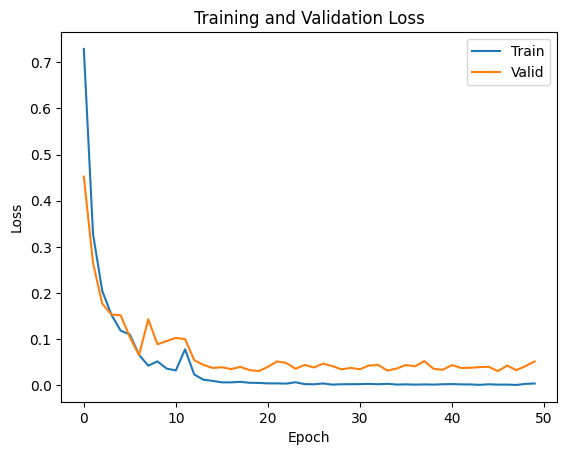

In [4]:
df = pd.read_csv("/content/drive/MyDrive/projects/1_Image_classification/1_brain_tumor/1_VGG16/files/CSVLogger/VGG16_classification_unfreeze.csv")

plt.plot(range(len(df['loss'].values)), df['loss'].values, label = 'Train')
plt.plot(range(len(df['val_loss'].values)), df['val_loss'].values, label = 'Valid')

plt.title("Training and Validation Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend()
plt.show()

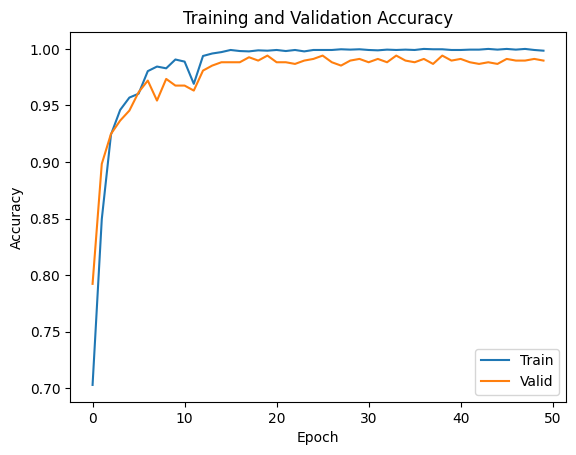

In [5]:
df = pd.read_csv("/content/drive/MyDrive/projects/1_Image_classification/1_brain_tumor/1_VGG16/files/CSVLogger/VGG16_classification_unfreeze.csv")

plt.plot(range(len(df['binary_accuracy'].values)), df['binary_accuracy'].values, label = 'Train')
plt.plot(range(len(df['val_binary_accuracy'].values)), df['val_binary_accuracy'].values, label = 'Valid')
plt.title('Training and Validation Accuracy')
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend()
plt.show()

#5: Model evaluation

##5.1: Test the model's predictions on 8 random images

Found 679 images belonging to 2 classes.
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 

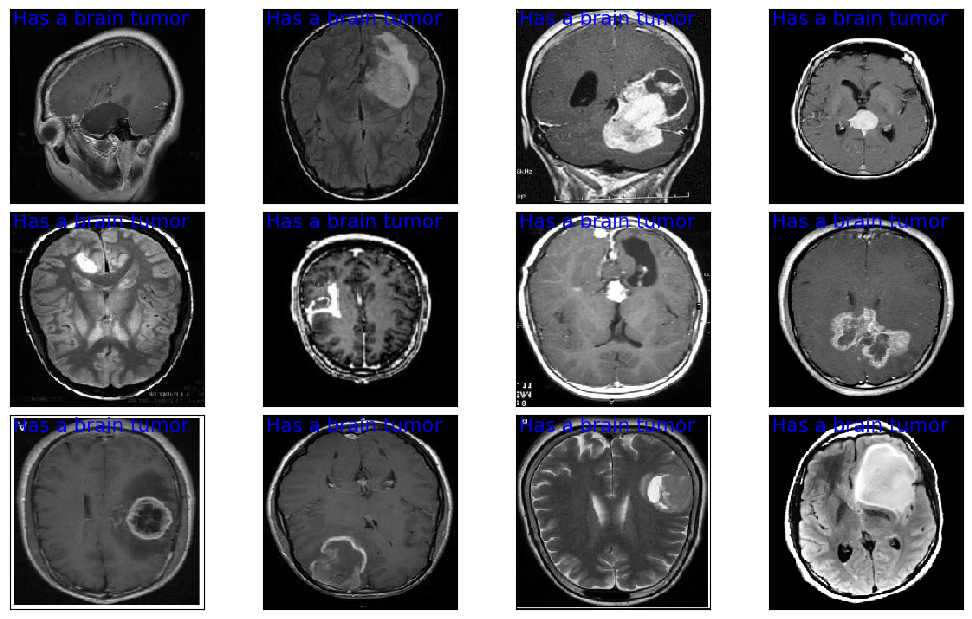

In [ ]:
test_dir = "/content/drive/MyDrive/projects/1_Image_classification/1_brain_tumor/datasets/slit_brain_tumor/test"
test_datagen = image.ImageDataGenerator(rescale= 1. / 255)
test_data = test_datagen.flow_from_directory(directory=test_dir,
                                             target_size=(224,224) ,
                                             batch_size=679,
                                             class_mode='binary',
                                             shuffle=False)

test_image, test_label  = next(test_data)
label_batch = test_label.astype(int)
print(label_batch)

class_names = ['Has a brain tumor', 'Brain healthy']
fig = plt.figure(figsize = (10, 6))
fig.subplots_adjust(left = 0, right = 1, bottom = 0, top = 1, hspace = 0.05, wspace = 0.05)

predicted = model.predict(test_image)
results = []

for i in range(len(predicted)):
    if predicted[i] < 0.5:
        results.append(0)
    else:
        results.append(1)
results = np.array(results)

for i in range(12):
    ax = fig.add_subplot(3, 4, i + 1, xticks=[], yticks=[])
    ax.imshow(test_image[i,:],cmap=plt.cm.gray_r, interpolation='nearest')

    if results[i] == label_batch[i]:
        ax.text(3, 17, class_names[results[i]], color='blue', fontsize=14)
    else:
        ax.text(3, 17, class_names[results[i]], color='red', fontsize=14)

##5.2: Model evaluation

In [ ]:
# Accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(label_batch, results)
print('Accuracy: %f' % accuracy)

# Precision tp / (tp + fp)
precision = precision_score(label_batch, results, average='macro')
print('Precision: %f' % precision)

# Recall: tp / (tp + fn)
recall = recall_score(label_batch, results, average='macro')
print('Recall: %f' % recall)

# F1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(label_batch, results, average='macro')
print('F1 score: %f' % f1)

# Area under ROC
auc = roc_auc_score(label_batch, results, multi_class='ovr')
print('ROC AUC: %f' % auc)

# Confusion matrix
matrix = confusion_matrix(label_batch, results)
print(matrix)

Accuracy: 0.992636
Precision: 0.992443
Recall: 0.992710
F1 score: 0.992574
ROC AUC: 0.992710
[[368   3]
 [  2 306]]


##5.3: Draw a chart of Confusion matrix

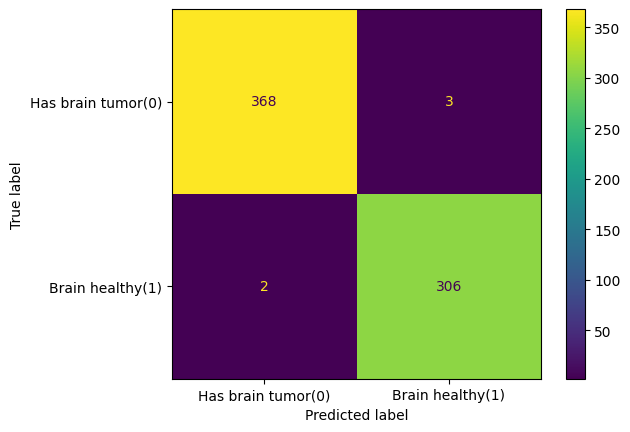

In [ ]:
labels = ["Has brain tumor(0)", "Brain healthy(1)"]

disp = ConfusionMatrixDisplay(confusion_matrix = matrix, display_labels = labels)

disp.plot()
plt.show()